In [ ]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt

import networkx as nx
import igraph as ig
import pandas as pd
import leidenalg

from src.utils.data_utils import load_graph_data
from src.data.graph import extract_players_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data loading

In [ ]:
graph_data = load_graph_data()
print("\nKeys:\n\t{}".format("    ".join(graph_data.keys())))


Keys:
	paths_finished    articles    links    shortest-path-distance-matrix    categories    paths_unfinished    graph


In [ ]:
finished_graph = extract_players_graph(graph_data, True)

Note that 4 edges are present in 'paths_finished.tsv' but not in 'links.tsv':
{('Republic_of_Ireland', 'Éire'), ('Claude_Monet', 'Édouard_Manet'), ('Finland', 'Åland'), ('Bird', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License')}


### Analyzing edges

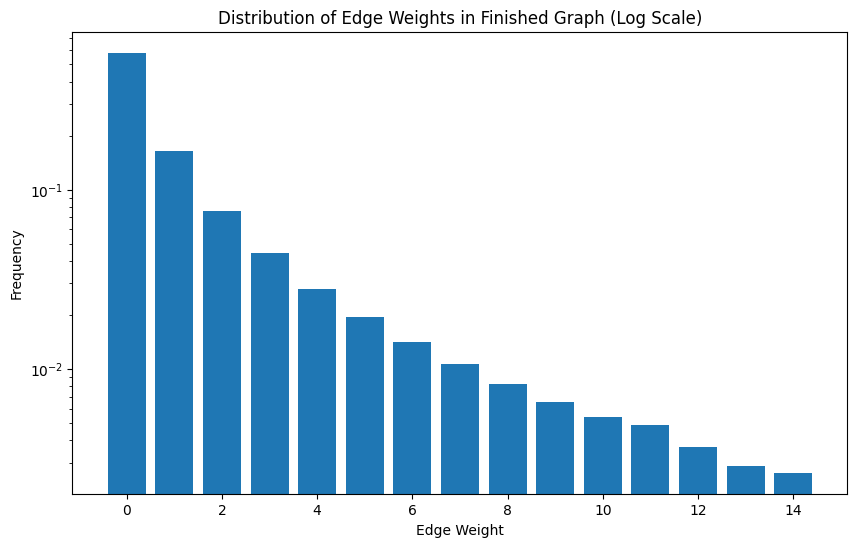

{0: 0.5799823278978231, 1: 0.164848582215439, 2: 0.07611053096634268, 3: 0.04434894369025624, 4: 0.02793798698690658, 5: 0.01959193509518837, 6: 0.014129648967788577, 7: 0.01068358904329665, 8: 0.008209494738533215, 9: 0.006586874447746807, 10: 0.005381958390232147, 11: 0.0048598280986424615, 12: 0.003662944814844566, 13: 0.0028757329906016547, 14: 0.002642782552815487, 15: 0.0022411438669772674, 16: 0.0022491766406940315, 17: 0.0019358984657402202, 18: 0.0016868824805205238, 19: 0.0014619648164511205, 20: 0.0012531126998152461, 21: 0.0012209816049481887, 22: 0.0009960639408787854, 23: 0.0010442605831793717, 24: 0.0009077034299943771, 25: 0.0007791790505261467, 26: 0.0005944252550405655, 27: 0.0005863924813238012, 28: 0.0005703269338902723, 29: 0.0005944252550405655, 30: 0.0004337697807052775, 31: 0.00044180255442204195, 32: 0.0004337697807052775, 33: 0.00038557313840469114, 34: 0.00030524540123704716, 35: 0.00038557313840469114, 36: 0.00023295043778616756, 37: 0.0003614748172543979, 3

In [ ]:
# Extract edge weights
weights = [data["weight"] for _, _, data in finished_graph.edges(data=True)]
num_edges = len(weights)
frequencies = {w: weights.count(w) / num_edges for w in set(weights)}

# Cut off the tail for better visualization
cutoff = 0.0023
filtered_frequencies = {k: v for k, v in frequencies.items() if v >= cutoff}

# Plot filtered_frequencies with log scale
plt.figure(figsize=(10, 6))
plt.bar(filtered_frequencies.keys(), filtered_frequencies.values())
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Edge Weights in Finished Graph (Log Scale)")
plt.show()

print(frequencies)

As we can see in the above graph, 57% of the hyperlinks were never clicked by any user, 16% of the hyperlinks were clicked only once and 7% of the hyperlinks were clicked twice. Let's take a closer look at that.

Below are the 20 most clicked hyperlinks by any user

In [ ]:
edges: list[int] = [(u, v, data["weight"]) for u, v, data in finished_graph.edges.data()]
edges = pd.DataFrame(edges, columns=["from", "to", "weight"]).sort_values("weight", ascending=False).reset_index(drop=True)
edges.iloc[:20]

,from,to,weight
0,Communication,Telephone,536
1,North_America,United_States,487
2,Animal,Mammal,483
3,United_States,President_of_the_United_States,473
4,Lion,Zebra,472
5,Europe,United_Kingdom,464
6,Brain,Computer_science,463
7,Mammal,Zebra,462
8,Norway,Viking,411
9,England,Europe,373


### Analyzing Nodes

###### Components

In [ ]:
nx.number_connected_components(finished_graph.to_undirected())

1

#### In-Degree
The in-degree of an article is the number of hyperlinks pointing towards that article

Articles with the highest in-degree:

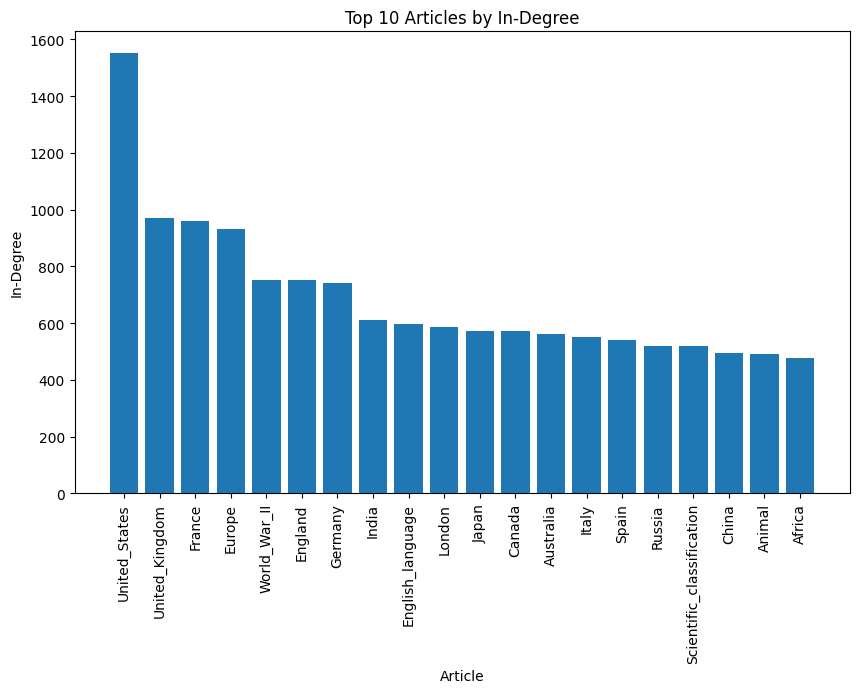

In [ ]:
in_degrees = pd.DataFrame(finished_graph.in_degree, columns=["article", "inDegree"])
in_degrees_sorted = in_degrees.sort_values("inDegree", ascending=False).iloc[1:21]  # Skipping the first node which is '<'

plt.figure(figsize=(10, 6))
plt.bar(in_degrees_sorted["article"], in_degrees_sorted["inDegree"])
plt.xlabel("Article")
plt.ylabel("In-Degree")
plt.title("Top 10 Articles by In-Degree")
plt.xticks(rotation=90)
plt.show()

Articles with in-degree 0. There is no hyperlink pointing towards these articles and they can never be reached from another article. Those articles are also called orphan articles.

In [ ]:
in_degrees.query("inDegree == 0")

,article,inDegree
1,Áedán_mac_Gabráin,0
5,Óengus_I_of_the_Picts,0
6,€2_commemorative_coins,0
35,2005_Hertfordshire_Oil_Storage_Terminal_fire,0
37,2005_Lake_Tanganyika_earthquake,0
...,...,...
4567,Yellowhammer,0
4576,Yotsuya_Kaidan,0
4577,You're_Still_the_One,0
4581,"Yungay,_Peru",0


As we can see, there are 465 unreachable articles.

#### Out-Degree

The out-degree of an article is the number of hyperlinks in that article

Articles with the highest out-degree

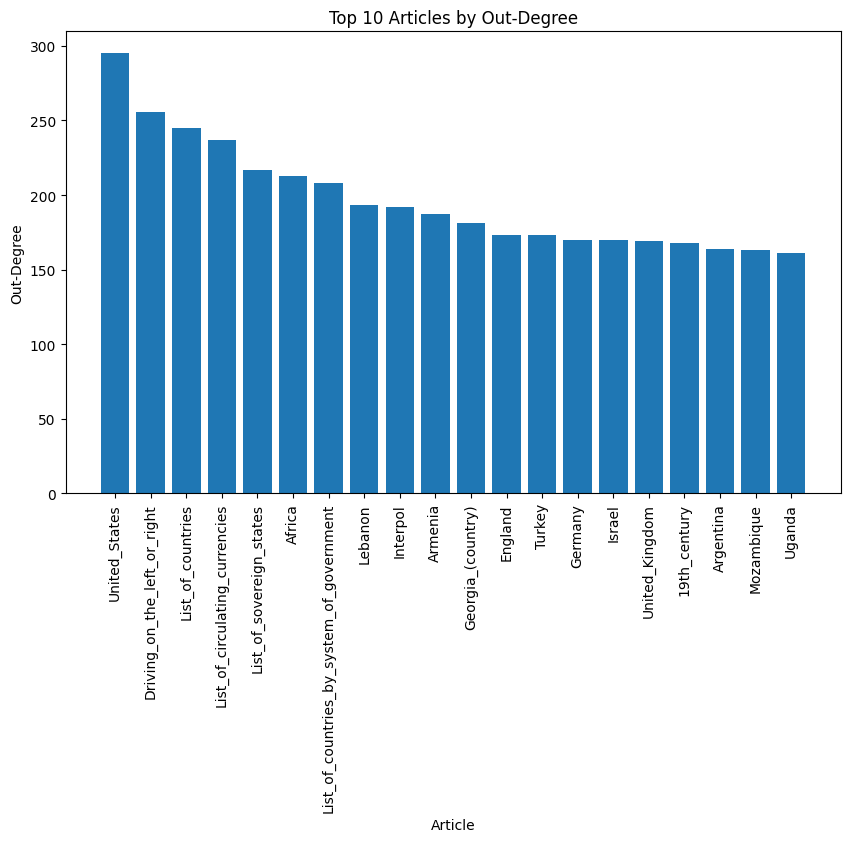

In [ ]:
out_degrees = pd.DataFrame(finished_graph.out_degree, columns=["article", "outDegree"])
out_degrees_sorted = out_degrees.sort_values("outDegree", ascending=False).iloc[:20]

plt.figure(figsize=(10, 6))
plt.bar(out_degrees_sorted["article"], out_degrees_sorted["outDegree"])
plt.xlabel("Article")
plt.ylabel("Out-Degree")
plt.title("Top 10 Articles by Out-Degree")
plt.xticks(rotation=90)
plt.show()

In [ ]:
out_degrees.query("outDegree == 0")

,article,outDegree
0,<,0


There are no node with out-degree 0. Every article has at least one hyperlink in it.

### Community detection

It can be interesting to explore how articles are connected to each other. Community analysis is a powerful tool for uncovering hidden structures in the Wikipedia graph, revealing what group of articles form communities, i.e. group of nodes that are densely connected internally. For that, we use the Leiden algorithm, a community-detection algorithm that works well for huge directed graph.

The detected communities can also help us further analyze players' behaviors by studying how they navigate across communities.

In [ ]:
communities = leidenalg.find_partition(
	ig.Graph.from_networkx(finished_graph), leidenalg.RBConfigurationVertexPartition, n_iterations=20, seed=2024
)
node_names = {i: node for i, node in enumerate(finished_graph.nodes())}
for i, community in enumerate(communities):
	print(f"Community {i}, {len(community)}: {[node_names[node] for node in community]}")

Community 0, 859: ['Åland', 'Édouard_Manet', '€2_commemorative_coins', '10th_century', '11th_century', '12th_century', '13th_century', '14th_century', '15th_century', '16th_century', '1755_Lisbon_earthquake', '17th_century', '1896_Summer_Olympics', '18th_century', '19th_century', '1st_century', '1st_century_BC', '20th_century', '2nd_century', '3rd_century', '4th_century', '5th_century', '6th_century', '7th_century', '8th_century', '9th_century', 'A_Wrinkle_in_Time', 'A_cappella', 'Aachen', 'Aarhus', 'Abkhazia', 'Able_Archer_83', 'Abraham_Goldfaden', 'Abstract_art', 'Achilles', 'Achilles_tendon', 'Actuary', 'Adam_Smith', 'Adolf_Hitler', 'Adriaen_van_der_Donck', 'Aesthetics', 'Agamemnon', 'Age_of_Enlightenment', 'Agnosticism', 'Akhenaten', 'Albigensian_Crusade', 'Albrecht_Dürer', 'Albrecht_Rodenbach', 'Alcibiades', 'Aleksandr_Pushkin', 'Aleksandr_Vasilevsky', 'Aleksey_Arakcheyev', 'Alexander_the_Great', 'Alfred_Nobel', 'Allegory_in_the_Middle_Ages', 'Amish', 'Amsterdam', 'Analytical_Marx

Below are the detected communities:
- Community 0 - **Europe 🇪🇺**. This community includes articles related to European countries, cities, landmarks, and notable figures.
- Community 1 - **Biology 🌱**. Comprising articles on animals, plants, and various natural sciences.
- Community 2 - **USA 🦅**. This community covers a wide range of topics related to the United States, including states, historical events, presidents, and prominent figures.
- Community 3 - **Africa, Asia and South America 🌍**. This community contains articles about countries, history, and cultures across Africa, Asia, and South America.
- Community 4 - **Astronomy, chemistry, physics and maths ⚛️**. This community brings together articles on celestial bodies, the periodic table and physics and maths.
- Community 5 - **United Kingdom 🇬🇧**. Articles within this community delve into British history, culture, politics, notable figures, and cities.
- Community 6 - **Computer Science 🤖**. Our favorite one, here we can find articles about programming languages, operating systems, ...
- Community 7 - **Tennis 🥎**. A small community of 23 articles, all about Tennis.
- Community 8 - **Tour de France 🚴**. The smallest community with 5 articles about the prestigious Tour de France.